In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTS

In [3]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F
SEED = 2019
torch.manual_seed(SEED)


# LOADING DATA

In [4]:
dir = "drive/MyDrive/Auto-Completion-Using-Neural-Language-Model/"

In [5]:
with open(dir + "Dailog-Dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [6]:
len(dialogs)

64776

In [8]:
random.sample(dialogs, 5)

["Let's do that one then",
 'I can do that',
 "That's what I'm talking about",
 'Thanks so much Donna!',
 'Well, my car is making a strange noise, so I need to take it to the car repair shop']

['Thanks again, goodbye',
 'What about a table',
 'I want Italian sausage and mushrooms',
 'Yes can you order me a pizza from Pizza Hut?',
 'Can I also add a medium pizza just plain cheese']

# PREPROCESSING

## TEXT CLEANING

In [9]:
dialogs_clean = []

for i in dialogs:
  i = re.sub("[^a-zA-Z' ]", "", i)
  i = i.lower()
  dialogs_clean.append(i)

In [10]:
random.sample(dialogs_clean, 5)

['a mocha frappuccino with whipped cream',
 ' that is all',
 'hey i need you to schedule me an appointment at a repair shop',
 "hi i'd like call in a lyft",
 "i'd like to see the movie alita battle angel"]


## WORD COUNT

In [11]:
all_words = " ".join(dialogs_clean).split()

words_dict = {}

for word in all_words:   
  if word in words_dict:
    words_dict[word] = words_dict[word] + 1
  else:
    words_dict[word] = 1

In [12]:
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})
words_df = words_df.sort_values(by = ['count'])
words_df.reset_index(inplace = True, drop=True)

In [13]:
len(words_df)

11147

In [14]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [15]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


## REPLACE RARE WORDS WITH <unk> TOKEN

In [16]:
rare_thresh = 4

In [17]:
# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")

Rare words distribution in the vocabulary: 69.03


In [18]:
# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words coverage in the corpus: 2.27


In [19]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

In [20]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern += " " + i + " |"
pattern = pattern[:-1]

In [21]:
dialogs_clean_v2 = []
for d in tqdm_notebook(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [23]:
random.sample(dialogs_clean_v2, 10)

['okay i will pay you back when you get here',
 'thanks have a good night',
 'yes could you direct me to the restroom',
 'can you find me seafood restaurants in the area',
 'ok sounds good to me',
 'im thinking about an iced <unk> latte',
 'no thank you',
 'hi i want movie tickets',
 'a peppermint mocha frappachino',
 'yes that one']

# DATA PREPARATION

## PREPARE SEQUENCE

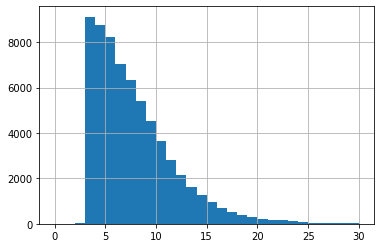

In [24]:
# get length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

In [25]:
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(0, len(text.split()) - seq_len):
      seq = text.split()[i:i + seq_len + 1]
      sequences.append(" ".join(seq))
    return sequences

  else:
    
    return [text]

In [26]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

In [27]:
seqs[:2]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village']]

In [28]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [29]:
seqs[:10]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the"]

In [30]:
len(seqs)

205346

In [31]:
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [32]:
x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [33]:
x[88543], y[88543]

('to drive to several locations', 'drive to several locations do')

## CREATE TOKEN-INTEGER MAPPING AND VICE VERSA

In [34]:
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

token2int = {t: i for i, t in int2token.items()}

In [35]:
token2int["can"], int2token[1127]

(1726, 'rotor')

## TRAIN / VAL SPLIT

In [36]:
x_tr = x[:150000]
y_tr = y[:150000]

x_val = x[150000:]
y_val = y[150000:]

## PAD SEQUENCES

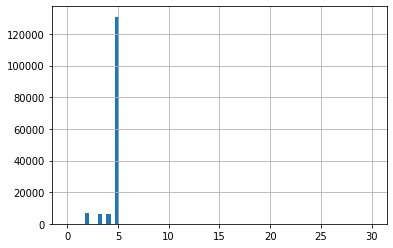

In [37]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [38]:
def pad_sequence(seq, n):

  seq = seq.split()
  
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

In [39]:
# based on the plot above
max_text_len = 5

In [40]:
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [41]:
random.sample(x_tr_padded, 10)

['is a <unk> for the',
 'try and get me a',
 'you also get me a',
 'and the date is fast',
 'what times are available are',
 'ok that one will <pad>',
 'what kind of snacks do',
 'so now <pad> <pad> <pad>',
 'really want the pizza and',
 'and how much is the']

In [42]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

In [43]:
# set vocabulary size
vocab_size = len(int2token)

## CONVERT TEXT TO INTEGER SEQUENCES

In [44]:
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [45]:
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [46]:
x_tr_int[:10]

[[1774, 6144, 6211, 6021, 4981],
 [6144, 6211, 6021, 4981, 6239],
 [6211, 6021, 4981, 6239, 5645],
 [6021, 4981, 6239, 5645, 2897],
 [4981, 6239, 5645, 2897, 5133],
 [2734, 1935, 214, 3116, 4554],
 [1935, 214, 3116, 4554, 238],
 [214, 3116, 4554, 238, 2919],
 [684, 3507, 128, 6021, 691],
 [3507, 128, 6021, 691, 3757]]

In [47]:
y_tr_int[:10]

[[6144, 6211, 6021, 4981, 6239],
 [6211, 6021, 4981, 6239, 5645],
 [6021, 4981, 6239, 5645, 2897],
 [4981, 6239, 5645, 2897, 5133],
 [6239, 5645, 2897, 5133, 4389],
 [1935, 214, 3116, 4554, 238],
 [214, 3116, 4554, 238, 2919],
 [3116, 4554, 238, 2919, 4840],
 [3507, 128, 6021, 691, 3757],
 [128, 6021, 691, 3757, 238]]

In [48]:
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

# MODEL

## ARCHITECTURE

In [49]:
class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden = 256, n_layers = 2, drop_prob = 0.3, lr = 0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    self.dropout = nn.Dropout(drop_prob)
    
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    
    embedded = self.emb_layer(x)     
    
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    out = self.dropout(lstm_output)
    
    out = out.reshape(-1, self.n_hidden)

    out = self.fc(out)

    return out, hidden
    
    
  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

In [50]:
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6502, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6502, bias=True)
)


In [51]:
def get_batches(arr_x, arr_y, batch_size):
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    x = arr_x[prv:n,:]
    y = arr_y[prv:n,:]
    prv = n
    yield x, y

## TRAINING

In [52]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
      
  best_valid_loss = float('inf')
  
  opt = torch.optim.Adam(net.parameters(), lr = lr)
  
  criterion = nn.CrossEntropyLoss()
  
  if(torch.cuda.is_available()):
    net.cuda()
  
  counter = 0

  net.train()

  for e in range(epochs):
            

    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1
      
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(torch.cuda.is_available()):
        inputs, targets = inputs.cuda(), targets.cuda()

      h = net.init_hidden(batch_size)

      # set accumulated gradients to zero
      net.zero_grad()
      
      output, h = net(inputs, h)
      
      loss = criterion(output, targets.view(-1))
      
      loss.backward()
      
      opt.step()
      
      if counter % print_every == 0:
        
        val_losses = []

        net.eval()

        for x, y in get_batches(x_val_int, y_val_int, batch_size):
            
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          
          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), 'saved_weights.pt')

        net.train()

      
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [53]:
# specify batch size
batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=10)

Epoch: 1/10... Step: 32... Loss: 6.4242... ppl: 675.5272  Val Loss: 6.5155
Epoch: 1/10... Step: 64... Loss: 5.6527... ppl: 340.7983  Val Loss: 5.8313
Epoch: 1/10... Step: 96... Loss: 6.0215... ppl: 270.7575  Val Loss: 5.6012
Epoch: 1/10... Step: 128... Loss: 5.2435... ppl: 233.4948  Val Loss: 5.4532
Epoch: 1/10... Step: 160... Loss: 6.1583... ppl: 205.0417  Val Loss: 5.3232
Epoch: 1/10... Step: 192... Loss: 5.7276... ppl: 181.2442  Val Loss: 5.1998
Epoch: 1/10... Step: 224... Loss: 5.1447... ppl: 163.8765  Val Loss: 5.0991
Epoch: 1/10... Step: 256... Loss: 4.2683... ppl: 149.1482  Val Loss: 5.0049
Epoch: 1/10... Step: 288... Loss: 4.8150... ppl: 136.9335  Val Loss: 4.9195
Epoch: 1/10... Step: 320... Loss: 4.9435... ppl: 127.6104  Val Loss: 4.8490
Epoch: 1/10... Step: 352... Loss: 4.3801... ppl: 119.3279  Val Loss: 4.7819
Epoch: 1/10... Step: 384... Loss: 5.0353... ppl: 112.3799  Val Loss: 4.7219
Epoch: 1/10... Step: 416... Loss: 4.9005... ppl: 106.7800  Val Loss: 4.6708
Epoch: 1/10... 

# TEXT GENERATION

In [54]:
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [55]:
def predict(net, tkn, h=None):
         
  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  if(torch.cuda.is_available()):
      inputs = inputs.cuda()

  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  
  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h

In [56]:
def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [59]:
# seed texts
seeds = ["i want to"]

# number of tokens to generate
num_toks = 10

for s in seeds:
  text_gen = sample(net, num_toks, seed_text = s)
  print("seed text:", s, ">> output:",text_gen)

seed text: i want to >> output: i want to order a coffee drink from starbucks for me please order
